In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_sample_image
from skimage.color import rgb2gray
from skimage.transform import resize, rescale
from skimage.io import imread, imsave, imshow

import os

In [2]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def random_batch(X, y, batch_size):
    permute_idx = np.random.permutation(len(X))
    for idx in np.array_split(permute_idx, batch_size):
        yield X[idx], y[idx]

In [4]:
reset_graph()

In [8]:
china = load_sample_image('china.jpg')
flower = load_sample_image('flower.jpg')

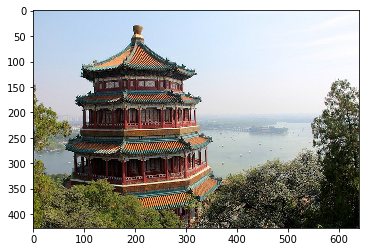

In [7]:
plt.imshow(china)

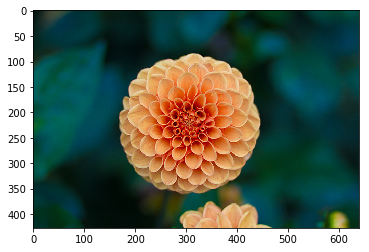

In [9]:
plt.imshow(flower)

In [12]:
china.shape, flower.shape

((427, 640, 3), (427, 640, 3))

In [13]:
china_grey = rgb2gray(china)
flower_grey = rgb2gray(flower)

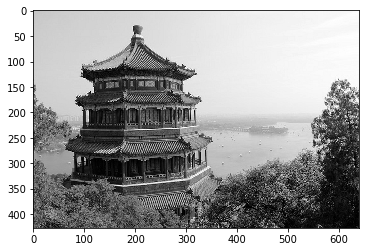

In [19]:
plt.imshow(china_grey, cmap=plt.cm.gray)

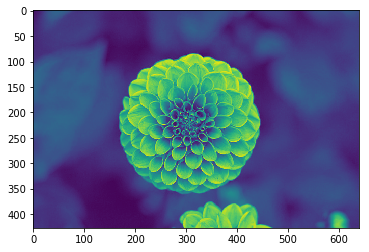

In [16]:
plt.imshow(flower_grey)

#### tensorflow convolutional layer

In [47]:
china = china[150:220, 130:250]
data = np.array([china], dtype=np.float32)

In [48]:
batch_size, height, width, channels = data.shape

In [49]:
# 2 filters 7 x 7
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1.     # vertical line
filters[3, :, :, 1] = 1.     # horizontal line

In [50]:
reset_graph()

X = tf.placeholder(dtype=tf.float32, shape=(None, height, width, channels), name='X')

convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding='SAME')

In [51]:
with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X:data})

Text(0.5,1,'vertical line filter')

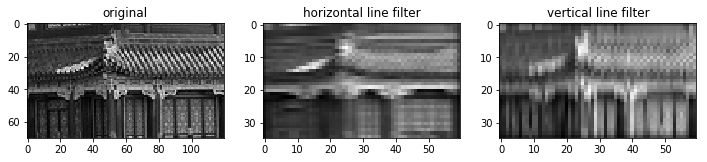

In [53]:
plt.figure(figsize=(12, 3))
plt.subplot('131')
plt.imshow(rgb2gray(china), cmap=plt.cm.gray)
plt.title('original')

plt.subplot('132')
plt.imshow(output[0, :, :, 1], cmap=plt.cm.gray)
plt.title('horizontal line filter')

plt.subplot('133')
plt.imshow(output[0, :, :, 0], cmap=plt.cm.gray)
plt.title('vertical line filter')

#### Pooling layer

In [54]:
reset_graph()

china = load_sample_image('china.jpg')

dataset = np.array([china], dtype=np.float32)
n, h, w, c = dataset.shape

In [55]:
n, h, w, c

(1, 427, 640, 3)

In [56]:
reset_graph()
X = tf.placeholder(shape=(None, h, w, c), dtype=tf.float32, name='X')
pooling = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

with tf.Session() as sess:
    output = sess.run(pooling, feed_dict={X:dataset})

Text(0.5,1,'after max pooling')

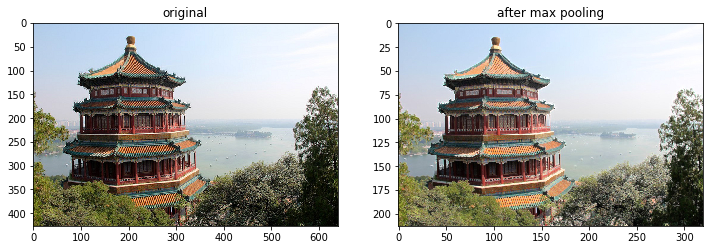

In [71]:
fig = plt.figure(figsize=(12, 6))
plt.subplot('121')
plt.imshow(china)
plt.title('original')

plt.subplot('122')
plt.imshow(output[0].astype('uint8'))
plt.title('after max pooling')

#### MNIST

In [78]:
from keras.datasets.mnist import load_data
(X_train, y_train), (X_test, y_test) = load_data()

In [79]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [80]:
X_train = X_train[:, :, :, None].astype(np.float32)
X_test = X_test[:, :, :, None].astype(np.float32)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [82]:
reset_graph()

width, height, channel = 28, 28, 1
conv1_channel = 32
conv2_channel = 64
fc_hidden = 64
outputs = 10

with tf.name_scope('inputs'):
    X = tf.placeholder(shape=(None, height, width, channel), dtype=tf.float32, name='X')
    y = tf.placeholder(shape=(None), dtype=tf.int32, name='y')
    
conv1 = tf.layers.conv2d(X, filters=conv1_channel, kernel_size=3, strides=1,
                         padding='SAME', activation=tf.nn.relu, name='conv1')
conv2 = tf.layers.conv2d(conv1, filters=conv2_channel, kernel_size=3, strides=2,
                         padding='SAME', activation=tf.nn.relu, name='conv2')

with tf.name_scope('pool3'):
    pool3 = tf.layers.max_pooling2d(conv2, pool_size=2, strides=2, padding='valid')
    pool3_flat = tf.reshape(pool3, shape=(-1, conv2_channel*7*7))
    
fc1 = tf.layers.dense(pool3_flat, fc_hidden, activation=tf.nn.relu, name='fc1')
with tf.name_scope('outputs'):
    logits = tf.layers.dense(fc1, outputs, activation=None, name='logits')
    y_proba = tf.nn.softmax(logits, axis=1, name='y_proba')

with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, k=1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss)
    
with tf.name_scope('init_and_save'):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [86]:
n_epoch = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epoch):
        for X_batch, y_batch in random_batch(X_train, y_train, batch_size):
            sess.run(train_op, feed_dict={X:X_batch, y:y_batch})
        
        val_acc, val_loss = sess.run([accuracy, loss], feed_dict={X:X_test, y:y_test})
        print('Epoch {:2d}, val-loss: {:.4f}, val-acc: {:.4f}'.format(epoch, val_loss, val_acc))

Epoch  0, val-loss: 0.1404, val-acc: 0.9582
Epoch  1, val-loss: 0.0872, val-acc: 0.9724
Epoch  2, val-loss: 0.0733, val-acc: 0.9769
Epoch  3, val-loss: 0.0642, val-acc: 0.9810
Epoch  4, val-loss: 0.0635, val-acc: 0.9808
Epoch  5, val-loss: 0.0603, val-acc: 0.9826
Epoch  6, val-loss: 0.0609, val-acc: 0.9824
Epoch  7, val-loss: 0.0597, val-acc: 0.9838
Epoch  8, val-loss: 0.0653, val-acc: 0.9841
Epoch  9, val-loss: 0.0619, val-acc: 0.9836


#### ex7. High Accuracy CNN for MNIST

In [100]:
rnd_idx = np.random.permutation(len(X_train))
X_train = X_train[rnd_idx]
y_train = y_train[rnd_idx]

X_val = X_train[:5000]
y_val = y_train[:5000]
X_train = X_train[5000:]
y_train = y_train[5000:]

In [109]:
h, w, c = 28, 28, 1
kernel_size = 3
stride = 1
padding = 'SAME'
conv2_dropout = .25
fc_dropout = .5
conv1_filter = 32
conv2_filter = 64
fc_hidden = 128
n_outputs = 10

reset_graph()

with tf.name_scope('inputs'):
    X = tf.placeholder(shape=(None, h, w, c), dtype=tf.float32, name='X')
    y = tf.placeholder(shape=(None), dtype=tf.int32, name='y')
    is_train = tf.placeholder_with_default(False, shape=(), name='is_train')
    
conv1 = tf.layers.conv2d(X, conv1_filter, kernel_size=kernel_size, strides=1, 
                         padding='SAME', activation=tf.nn.relu)
conv2 = tf.layers.conv2d(conv1, conv2_filter, kernel_size=kernel_size, strides=1,
                         padding='SAME', activation=tf.nn.relu)

with tf.name_scope('pool3'):
    pool3 = tf.layers.max_pooling2d(conv2, pool_size=(2,2), strides=(2,2), padding='valid')
    pool3_flat = tf.reshape(pool3, shape=(-1, conv2_filter*14*14))
    pool3_dropout = tf.layers.dropout(pool3_flat, rate=conv2_dropout, training=is_train)
    
with tf.name_scope('fc1'):
    fc1 = tf.layers.dense(pool3_dropout, fc_hidden, activation=tf.nn.elu, name='fc1')
    fc1_dropout = tf.layers.dropout(fc1, rate=fc_dropout, training=is_train)
    
with tf.name_scope('outputs'):
    logits = tf.layers.dense(fc1_dropout, n_outputs, activation=None, name='logits')
    y_proba = tf.nn.softmax(logits, axis=1, name='y_proba')
    
with tf.name_scope('train'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy, name='loss')
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, k=1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [139]:
def get_model_params():
    '''return a dict with variable_names as keys
    and variable_values as values'''
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name:values for gvar, values 
            in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model(params):
    gvar_names = list(params.keys())
    gvar_assign_ops = {name: tf.get_default_graph().get_operation_by_name(name+'/Assign') 
                       for name in gvar_names}
    gvar_assign_inits = {name: assign.inputs[1] for name, assign in gvar_assign_ops.items()}
    feed_dict = {gvar_assign_inits[name]:params[name] for name in gvar_names}
    tf.get_default_session().run(gvar_assign_ops, feed_dict=feed_dict)

In [141]:
n_epoch = 1000
batch_size = 50

max_no_progress = 20
no_progress_count = 0
best_loss = np.infty
best_param = None
check_interval = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epoch):
        for i, (X_batch, y_batch) in enumerate(random_batch(X_train, y_train, batch_size)):
            sess.run(train_op, feed_dict={X:X_batch, y:y_batch, is_train:True})
            
            if i%check_interval==0:
                val_loss = sess.run(loss, feed_dict={X:X_val, y:y_val, is_train:False})
                if val_loss < best_loss:
                    best_loss = val_loss
                    no_progress_count = 0
                    best_param = get_model_params()
                else:
                    no_progress_count += 1
                    
        tr_acc = sess.run(accuracy, feed_dict={X:X_batch, y:y_batch})
        val_acc = sess.run(accuracy, feed_dict={X:X_val, y:y_val})  
        print("Epoch {:4d}, tr-acc: {:.3f}, val-acc: {:.3f}, best-loss: {:.3f}".format(epoch, tr_acc, 
                                                                                       val_acc, best_loss))
        
        if no_progress_count > max_no_progress:
            print('Early stop')
            break
    
    if best_param:
        restore_model(best_param)
        
    acc_test = sess.run(accuracy, feed_dict={X:X_test, y:y_test})
    print("Test accuracy: {:4f}".format(acc_test))
    save_path = saver.save(sess, './my_cnn_mnist_model')

Epoch    0, tr-acc: 0.952, val-acc: 0.944, best-loss: 38.622
Epoch    1, tr-acc: 0.977, val-acc: 0.973, best-loss: 0.205
Epoch    2, tr-acc: 0.987, val-acc: 0.979, best-loss: 0.100
Epoch    3, tr-acc: 0.984, val-acc: 0.981, best-loss: 0.071
Epoch    4, tr-acc: 0.987, val-acc: 0.983, best-loss: 0.061
Epoch    5, tr-acc: 0.985, val-acc: 0.983, best-loss: 0.060
Epoch    6, tr-acc: 0.994, val-acc: 0.985, best-loss: 0.055
Epoch    7, tr-acc: 0.995, val-acc: 0.985, best-loss: 0.055
Epoch    8, tr-acc: 0.995, val-acc: 0.986, best-loss: 0.050
Epoch    9, tr-acc: 0.997, val-acc: 0.985, best-loss: 0.050
Epoch   10, tr-acc: 0.997, val-acc: 0.986, best-loss: 0.050
Epoch   11, tr-acc: 0.998, val-acc: 0.987, best-loss: 0.050
Epoch   12, tr-acc: 0.997, val-acc: 0.986, best-loss: 0.050
Epoch   13, tr-acc: 0.999, val-acc: 0.987, best-loss: 0.050
Epoch   14, tr-acc: 0.998, val-acc: 0.990, best-loss: 0.049
Epoch   15, tr-acc: 0.999, val-acc: 0.987, best-loss: 0.045
Epoch   16, tr-acc: 1.000, val-acc: 0.9

ResourceExhaustedError: OOM when allocating tensor with shape[10000,64,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_1/Conv2D = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d/Relu, conv2d_1/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'conv2d_1/Conv2D', defined at:
  File "C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\asyncio\base_events.py", line 421, in run_forever
    self._run_once()
  File "C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\asyncio\base_events.py", line 1425, in _run_once
    handle._run()
  File "C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\asyncio\events.py", line 127, in _run
    self._callback(*self._args)
  File "C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-109-f43a19b569c7>", line 22, in <module>
    padding='SAME', activation=tf.nn.relu)
  File "C:\Users\LENOVO\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\layers\convolutional.py", line 425, in conv2d
    return layer.apply(inputs)
  File "C:\Users\LENOVO\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\keras\engine\base_layer.py", line 805, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "C:\Users\LENOVO\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\layers\base.py", line 362, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "C:\Users\LENOVO\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\keras\engine\base_layer.py", line 736, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "C:\Users\LENOVO\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\keras\layers\convolutional.py", line 186, in call
    outputs = self._convolution_op(inputs, self.kernel)
  File "C:\Users\LENOVO\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\ops\nn_ops.py", line 868, in __call__
    return self.conv_op(inp, filter)
  File "C:\Users\LENOVO\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\ops\nn_ops.py", line 520, in __call__
    return self.call(inp, filter)
  File "C:\Users\LENOVO\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\ops\nn_ops.py", line 204, in __call__
    name=self.name)
  File "C:\Users\LENOVO\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 1043, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "C:\Users\LENOVO\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\LENOVO\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\LENOVO\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\framework\ops.py", line 3195, in create_op
    op_def=op_def)
  File "C:\Users\LENOVO\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[10000,64,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_1/Conv2D = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d/Relu, conv2d_1/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [150]:
with tf.Session() as sess:
    init.run()
    restore_model(best_param)
    acc_test = []
    for x_batch, y_batch in random_batch(X_test, y_test, batch_size=1000):
        ts_acc = sess.run(accuracy, feed_dict={X:x_batch, y:y_batch})
        acc_test.append(ts_acc*len(x_batch))
    print("Test accuracy: {:4f}".format(np.sum(acc_test)/len(X_test)))
    save_path = saver.save(sess, './my_cnn_mnist_model')

Test accuracy: 0.988900


In [151]:
reset_graph()

#### ex8. classifying large images using Inception v3

In [3]:
h, w, c = 299, 299, 3

In [4]:
image_files = os.listdir('animal_images/')
image_files = [os.path.join('animal_images', name) for name in image_files]
image_files

['animal_images\\alejandro-contreras-283147-unsplash.jpg',
 'animal_images\\daniel-sandoval-433000-unsplash.jpg',
 'animal_images\\david-clode-363878-unsplash.jpg',
 'animal_images\\harshil-gudka-616909-unsplash.jpg',
 'animal_images\\james-hammond-347179-unsplash.jpg',
 'animal_images\\jared-rice-388266-unsplash.jpg',
 'animal_images\\josephine-amalie-paysen-302414-unsplash.jpg',
 'animal_images\\kyle-nieber-643745-unsplash.jpg',
 'animal_images\\steve-harvey-461969-unsplash.jpg',
 'animal_images\\wade-lambert-681674-unsplash.jpg']

In [5]:
images = np.empty(shape=(len(image_files), h, w, c), dtype=np.float32)
for i, file in enumerate(image_files):
    images[i] = imread(file)

In [6]:
images = images / 255.
images = 2*images - 1.

In [7]:
images.min(), images.max()

(-1.0, 1.0)

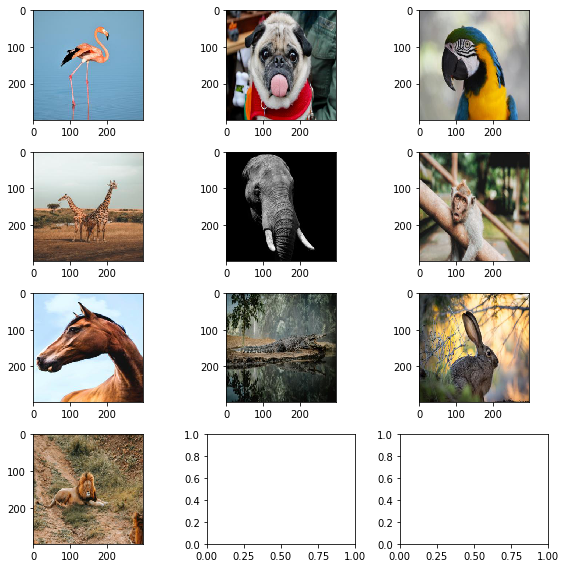

In [177]:
fig, ax = plt.subplots(ncols=3, nrows=4, figsize=(8, 8))

for axi, file in zip(ax.flat, image_files):
    img = imread(file)
    imshow(img, ax=axi)

In [21]:
import sys
from urllib.request import urlretrieve
import tarfile

In [8]:
inception_v3_url = 'http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz'
inception_path = os.path.join('datasets', 'inception')
inception_checkpoint = os.path.join(inception_path, 'inception_v3.ckpt')

In [32]:
def download_progress(count, block_size, total_size):
    percent = count*block_size*100 // total_size
    sys.stdout.write('\rDownloading {}%'.format(percent))
    sys.stdout.flush()
    
def fetch_pretrained_inception_v3(url=inception_v3_url, path=inception_path):
    if os.path.exists(inception_checkpoint):
        return
    os.makedirs(path, exist_ok=True)
    tar_path = os.path.join(path, 'inception_v3.tar.gz')
    urlretrieve(url, tar_path, reporthook=download_progress)
    with tarfile.open(tar_path) as tar:
        tar.extractall(path=path)
    os.remove(tar_path)

In [24]:
fetch_pretrained_inception_v3()

In [9]:
import re
class_file = 'datasets/inception/imagenet_class_names.txt'

In [10]:
with open(class_file, 'r') as f:
    txt = f.read()

In [11]:
txt[:100]

'n01440764 tench, Tinca tinca\nn01443537 goldfish, Carassius auratus\nn01484850 great white shark, whit'

In [12]:
pattern = r'n\d+\s+(.+)\s*'
class_names = ['background'] + re.findall(pattern, txt)

In [13]:
class_names[:5]

['background',
 'tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri']

In [14]:
# create Inception v3 model
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

In [15]:
reset_graph()

X = tf.placeholder(shape=(None, h, w, c), dtype=tf.float32, name='X')
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, endpoints = inception.inception_v3(X, num_classes=1001, is_training=False)

In [16]:
predictions = endpoints['Predictions']
saver = tf.train.Saver()
list(endpoints.keys())

['Mixed_6c',
 'MaxPool_3a_3x3',
 'Mixed_7a',
 'Mixed_5b',
 'Conv2d_4a_3x3',
 'Predictions',
 'PreLogits',
 'Conv2d_2a_3x3',
 'Conv2d_1a_3x3',
 'Mixed_5c',
 'AuxLogits',
 'Conv2d_3b_1x1',
 'Conv2d_2b_3x3',
 'Mixed_6d',
 'Mixed_6a',
 'Mixed_6b',
 'Mixed_7b',
 'Mixed_7c',
 'MaxPool_5a_3x3',
 'Logits',
 'Mixed_5d',
 'Mixed_6e']

In [17]:
# restore model
with tf.Session() as sess:
    saver.restore(sess, inception_checkpoint)

INFO:tensorflow:Restoring parameters from datasets\inception\inception_v3.ckpt


In [18]:
# restore model and predict some images
with tf.Session() as sess:
    saver.restore(sess, inception_checkpoint)
    y_pred = sess.run(predictions, feed_dict={X:images})

INFO:tensorflow:Restoring parameters from datasets\inception\inception_v3.ckpt


In [23]:
class_pred = [class_names[idx] for idx in np.argmax(y_pred, axis=1)]

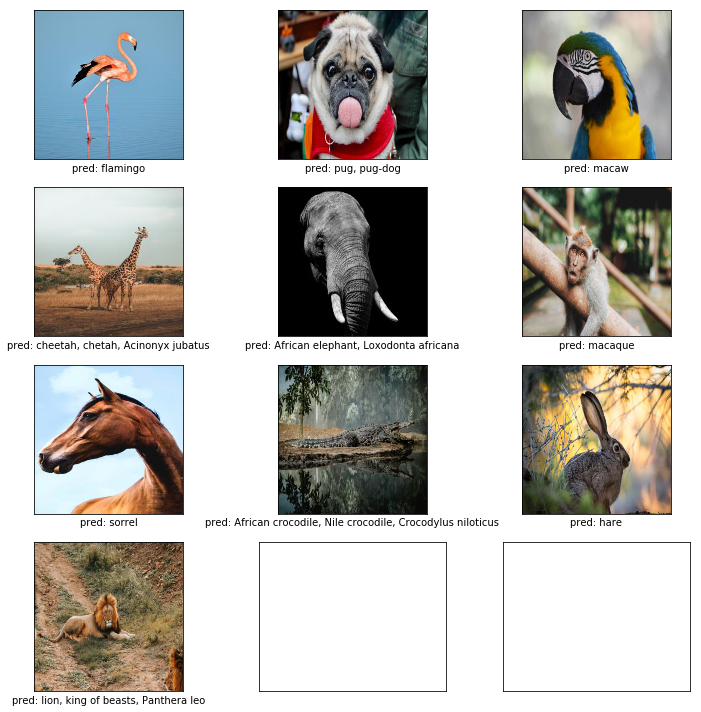

In [26]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(10, 10), 
                       subplot_kw={'xticks':[], 'yticks':[]})

for file, pred_label, axi in zip(image_files, class_pred, ax.flat):
    axi.imshow(imread(file))
    axi.set_xlabel('pred: {}'.format(pred_label))
    
fig.tight_layout()

#### ex9. Transfer learning for large image classification

In [29]:
import sys
from six.moves import urllib
import tarfile

In [27]:
FLOWERS_URL = "http://download.tensorflow.org/example_images/flower_photos.tgz"
FLOWERS_PATH = os.path.join("datasets", "flowers")

In [37]:
def fetch_flower(url=FLOWERS_URL, path=FLOWERS_PATH):
    os.makedirs(path, exist_ok=True)
    tar_path = os.path.join(path, 'flower_photos.tgz')
    urllib.request.urlretrieve(url, filename=tar_path, reporthook=download_progress)
    with tarfile.open(tar_path) as tar:
        tar.extractall(path)
    os.remove(tar_path)

In [38]:
fetch_flower()

In [40]:
flower_root_dir = os.path.join(FLOWERS_PATH, 'flower_photos')
flower_classes = sorted(name for name in os.listdir(flower_root_dir) 
                        if os.path.isdir(os.path.join(flower_root_dir, name)))

In [41]:
flower_classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [45]:
from collections import defaultdict

image_paths = defaultdict(list)

for flower_name in flower_classes:
    flower_dir = os.path.join(flower_root_dir, flower_name)
    for filename in os.listdir(flower_dir):
        if filename.lower().endswith('.jpg'):
            image_paths[flower_name].append(os.path.join(flower_dir, filename))

In [49]:
# sort filename
for values in image_paths.values():
    values.sort()

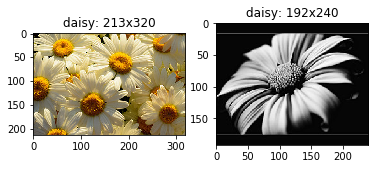

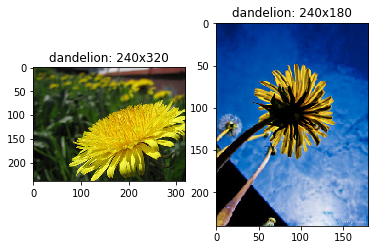

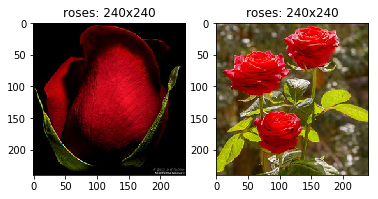

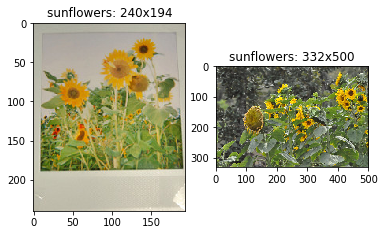

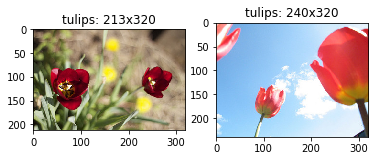

In [56]:
# display sample image
from skimage.io import imread


n_per_class = 2
for flower in flower_classes:
    for i in range(1, n_per_class+1):
        filename = np.random.choice(image_paths[flower], size=1)[0]
        plt.subplot('1{}{}'.format(n_per_class, i))
        img = imread(filename)
        plt.imshow(img)
        plt.title('{}: {}x{}'.format(flower, img.shape[0], img.shape[1]))
    plt.show()

In [70]:
from skimage.transform import resize

def prepare_image(img, target_width=299, target_height=299, zoom=0.2):
    height, width = img.shape[:2]
    image_ratio = width / height
    target_ratio = target_width / target_height
    
    # find correct bounding box
    crop_vertically = image_ratio < target_ratio
    crop_width = width if crop_vertically else int(target_ratio*height)
    crop_height = height if not crop_vertically else int(width/target_ratio)
    
    # zoom factor -> 1 - 1+zoom
    zoom_factor = np.random.random()*zoom + 1.
    crop_width = int(crop_width / zoom_factor)
    crop_height = int(crop_height / zoom_factor)
    
    # random crop
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    crop_img = img[y0:y0+crop_height, x0:x0+crop_width]
    
    # flip right left
    if np.random.random() > .5:
        crop_img = np.fliplr(crop_img)
        
    # resize to target image
    crop_img = resize(crop_img, output_shape=(target_height, target_width), 
                      mode='constant', anti_aliasing=True)
    
    return crop_img

Text(0.5,1,'shape:(333, 500, 3)')

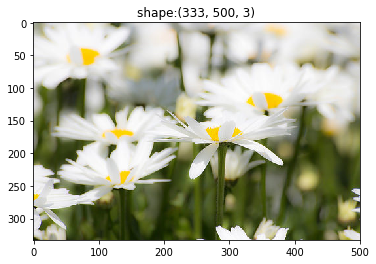

In [80]:
# sample image


f1 = image_paths['daisy'][100]

img = imread(f1)
plt.imshow(img)
plt.title('shape:{}'.format(img.shape))

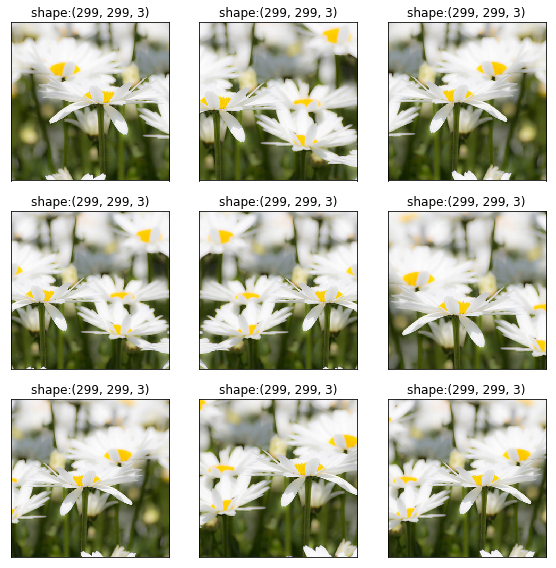

In [81]:
fig, axi = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), 
                        subplot_kw={'xticks':[], 'yticks':[]})

for ax in axi.flat:
    processed_img = prepare_image(img)

    ax.imshow(processed_img)
    ax.set_title('shape:{}'.format(processed_img.shape))
    
fig.tight_layout()

In [90]:
def prepare_image_with_tensorflow(image, target_width=299, target_height=299, zoom=0.2):
    
    # image ratio : target ratio 
    image_shape = tf.cast(tf.shape(image), dtype=tf.float32)
    width = image_shape[1]
    height = image_shape[0]
    image_ratio = width / height
    target_ratio = target_width / target_height
    crop_vertically = image_ratio < target_ratio
    crop_width = tf.cond(crop_vertically, 
                         lambda: width, 
                         lambda: target_ratio*width)
    crop_height = tf.cond(crop_vertically,
                         lambda: width/target_ratio,
                         lambda: height)
    
    # resize between [1, 1+zoom]
    resize_factor = tf.random_uniform(shape=(), minval=1, maxval=1+zoom)
    crop_width = tf.cast(crop_width/resize_factor, tf.int32)
    crop_height = tf.cast(crop_height/resize_factor, tf.int32)
    box_size = tf.stack([crop_height, crop_width, 3])
    # random crop
    image = tf.random_crop(image, size=box_size)
    
    # random flip
    image = tf.image.random_flip_left_right(image)
    
    # resize -> [target_height, target_width]
    image = tf.image.resize_bilinear(tf.expand_dims(image, 0), 
                                     [target_height, target_width])
    
    return image[0] / 255.

In [88]:
img.shape

(333, 500, 3)

In [91]:
reset_graph()

X = tf.placeholder(shape=(None, None, 3), dtype=tf.uint8)
output = prepare_image_with_tensorflow(X)

In [95]:
with tf.Session() as sess:
    prepared_img = sess.run(output, feed_dict={X:img})

Text(0.5,1,'shape: (299, 299, 3)')

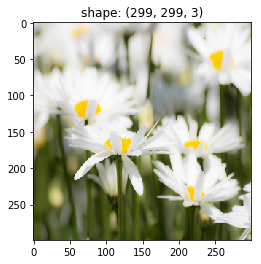

In [96]:
plt.imshow(prepared_img)
plt.title('shape: {}'.format(prepared_img.shape))

In [97]:
# 9.3 using Inception v3 model
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

In [99]:
inception_checkpoint

'datasets\\inception\\inception_v3.ckpt'

In [101]:
list(image_paths.keys())

['sunflowers', 'daisy', 'roses', 'dandelion', 'tulips']

In [116]:
flower_classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [119]:
reset_graph()

h, w, c = 299, 299, 3

X = tf.placeholder(shape=(None, h, w, c), dtype=tf.float32, name='X')
is_training = tf.placeholder_with_default(False, shape=(), name='is_training')
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, endpoints = inception.inception_v3(X, num_classes=1001, is_training=is_training)
    
inception_saver = tf.train.Saver()

In [120]:
prelogits = tf.squeeze(endpoints['PreLogits'], axis=[1, 2])

n_outputs = len(flower_classes)
with tf.name_scope('new_outputs'):
    flower_logits = tf.layers.dense(prelogits, n_outputs, activation=None, name='flower_logits')
    y_proba = tf.nn.softmax(flower_logits, axis=1, name='y_proba')

In [124]:
y = tf.placeholder(shape=(None), dtype=tf.int32, name='y')

with tf.name_scope('train'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=flower_logits)
    loss = tf.reduce_mean(xentropy, name='loss')
    optimizer = tf.train.AdamOptimizer()
    flower_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='flower_logits')
    train_op = optimizer.minimize(loss, var_list=flower_vars)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(flower_logits, y, k=1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')

with tf.name_scope('init_and_save'):
    flower_init = tf.global_variables_initializer()
    flower_saver = tf.train.Saver()

In [125]:
flower_vars

[<tf.Variable 'flower_logits/kernel:0' shape=(2048, 5) dtype=float32_ref>,
 <tf.Variable 'flower_logits/bias:0' shape=(5,) dtype=float32_ref>]

In [128]:
#image_paths
# create training set: > 100 samples for each class

flower2idx = {name:i for i,name in enumerate(flower_classes)}
flower2idx

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [129]:
filespath_and_label = []
for flower in flower_classes:
    for file in image_paths[flower]:
        filespath_and_label.append((file, flower2idx[flower]))

In [131]:
len(filespath_and_label)

3670

In [151]:
test_size = .2
n_train = int(len(filespath_and_label)*(1-test_size))

np.random.shuffle(filespath_and_label)

paths_and_labels_train = filespath_and_label[:n_train]
paths_and_labels_test = filespath_and_label[n_train:]

In [152]:
len(paths_and_labels_test), len(paths_and_labels_train)

(734, 2936)

In [132]:
from random import sample

In [133]:
def flower_batch(paths_and_labels, batch_size=8):
    samples = sample(paths_and_labels, k=batch_size)
    images = np.array([prepare_image(imread(file)) for file, _ in samples], dtype=np.float32)
    images = 2*images - 1.
    labels = np.array([label for _, label in samples], dtype=np.int32)
    return images, labels

In [149]:
a, b = flower_batch(filespath_and_label)

print(b)
a.shape, b.shape

[2 1 1 1 1 4 0 2]


((8, 299, 299, 3), (8,))

In [153]:
X_test, y_test = flower_batch(paths_and_labels_test, batch_size=len(paths_and_labels_test))
X_test.shape, y_test.shape

((734, 299, 299, 3), (734,))

In [156]:
n_epochs = 10
batch_size = 32
num_iter_per_epoch = len(paths_and_labels_train) // batch_size


with tf.Session() as sess:
    flower_init.run()
    inception_saver.restore(sess, inception_checkpoint)
    
    for epoch in range(n_epochs):
        print('Epoch {:3d}'.format(epoch), end='')
        for i in range(num_iter_per_epoch):
            X_batch, y_batch = flower_batch(paths_and_labels_train, batch_size=batch_size)
            sess.run(train_op, feed_dict={X:X_batch, y:y_batch, is_training:True})
            print('.', end='')
        print()
        tr_acc = sess.run(accuracy, feed_dict={X:X_batch, y:y_batch})
        #ts_acc = sess.run(accuracy, feed_dict={X:X_test, y:y_test})
        print("### train-acc: {:.4f} ###".format(tr_acc))
        
    flower_model_path = flower_saver.save(sess, './my_flowers_model')

INFO:tensorflow:Restoring parameters from datasets\inception\inception_v3.ckpt
Epoch   0...........................................................................................
### train-acc: 0.6562 ###
Epoch   1...........................................................................................
### train-acc: 0.6875 ###
Epoch   2...........................................................................................
### train-acc: 0.5312 ###
Epoch   3...........................................................................................
### train-acc: 0.6562 ###
Epoch   4...........................................................................................
### train-acc: 0.4688 ###
Epoch   5...........................................................................................
### train-acc: 0.7500 ###
Epoch   6...........................................................................................
### train-acc: 0.7188 ###
Epoch   7.......................

In [158]:
test_batch = 10
X_test_batch = np.array_split(X_test, test_batch)
y_test_batch = np.array_split(y_test, test_batch)

with tf.Session() as sess:
    flower_saver.restore(sess, flower_model_path)
    test_accuracy = np.mean([sess.run(accuracy, feed_dict={X:X_batch, y:y_batch}) 
                             for X_batch, y_batch in zip(X_test_batch, y_test_batch)])
    print('test-accuracy: {:.4f}'.format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./my_flowers_model
test-accuracy: 0.6773


In [111]:
logits.op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Conv2d_1c_1x1/BiasAdd:0' shape=(?, 1, 1, 1001) dtype=float32>

In [112]:
logits.op.inputs[0].op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Conv2d_1c_1x1/Conv2D:0' shape=(?, 1, 1, 1001) dtype=float32>

In [110]:
logits.op.inputs[0].op.inputs[0].op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

In [113]:
a = logits 
for i in range(5):
    a = a.op.inputs[0]
    print(a)

Tensor("InceptionV3/Logits/Conv2d_1c_1x1/BiasAdd:0", shape=(?, 1, 1, 1001), dtype=float32)
Tensor("InceptionV3/Logits/Conv2d_1c_1x1/Conv2D:0", shape=(?, 1, 1, 1001), dtype=float32)
Tensor("InceptionV3/Logits/Dropout_1b/cond/Merge:0", shape=(?, 1, 1, 2048), dtype=float32)
Tensor("InceptionV3/Logits/Dropout_1b/cond/Identity:0", shape=(?, 1, 1, 2048), dtype=float32)
Tensor("InceptionV3/Logits/Dropout_1b/cond/Identity/Switch:0", shape=(?, 1, 1, 2048), dtype=float32)


In [115]:
endpoints['PreLogits']

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>